In [1]:
import time
import pickle
from jetbot import Camera, bgr8_to_jpeg, Robot

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as torch_F
import torchvision

import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display, Image, clear_output

def display_image(image, text = None):
    if text is not None:
        position = (10, 10)  # (x, y) coordinates of the top left corner
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        color = (255, 255, 255)  # White color in BGR
        thickness = 2
        cv2.putText(image, text, position, font, font_scale, color, thickness)
    _, encoded_image = cv2.imencode('.jpg', image)
    clear_output(wait=True)
    display(Image(data=encoded_image.tobytes()))

robot = Robot()
robot.stop()
size = 128

In [2]:
camera = Camera.instance(width=size, height=size, capture_width=size, capture_height=size, fps=4)
image = widgets.Image(format='jpeg', width=size, height=size)
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [3]:
%%capture
# model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(num_classes=4)
model.load_state_dict(torch.load('./best_model.pth'))
model = model.cuda()
model.eval()

In [4]:
def preprocess(image):
    global model
#     torch_image = cv2.imread('./test_image.jpg')
#     torch_image = cv2.resize(torch_image, (size, size))
#     torch_image = cv2.cvtColor(torch_image, cv2.COLOR_BGR2RGB)
#     torch_image = torch.from_numpy(torch_image).float()


    np_image = image.astype(np.float32)
    np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2RGB)
    torch_image = torch.from_numpy(np_image).float()
    torch_image = torch_image / 255.0
    torch_image = torch_image.permute(2, 0, 1)
    torch_image = torch_image.unsqueeze(0)
    torch_image = torch_image.cuda()
    
    start = time.time()
    seg_image = model(torch_image)['out'].squeeze(0)
    seg_image = seg_image.permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)
    end = time.time()
    time_length = end - start
    
#     print(f"Segment time: {time_length:.2f}")
    return seg_image

In [11]:
def step(action):
    global robot
    # return
    if action == 0:
        robot.set_motors(0.12, -0.12)
    elif action == 1:
        robot.set_motors(0.12, 0.0)
    elif action == 2:
        robot.set_motors(0.0, -0.12)

In [6]:
def update(change):
    global camera
    processed_image = preprocess(camera.value)
    processed_image = np.argmax(processed_image, axis=2)
    color_image = np.zeros((size, size, 3), dtype=np.uint8)
    colors = {
        0: [0,0,0],   # black -> background
        1: [255,0,0],   # dark red -> road
        2: [0,255,0],   # light green -> mid road lane
        3: [255,255,0]  # yellow -> obstacle
    }
    for label, color in colors.items():
        color_image[processed_image == label] = color
    color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    
    ####################################################################
    ## Ruled Base
    mask_obstacle = (processed_image == 3).astype(np.uint8)
    mask_obstacle[:80, :] = 0
    mask_obstacle[100:, :] = 0
    res_obstacle = cv2.bitwise_and(color_image, color_image, mask=mask_obstacle)
    contours_obstacle, _ = cv2.findContours(mask_obstacle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    has_turned = False
    has_road = False
    state_text = None
    
    if contours_obstacle:
        largest_contour_obstacle = max(contours_obstacle, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour_obstacle)
        bbox_center_x, bbox_center_y = x + w // 2, y + h // 2
        cv2.rectangle(color_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.circle(color_image, (bbox_center_x, bbox_center_y), 3, (255, 0, 255), -1)
        if bbox_center_x < 64:
            step(1)
            state_text = 'Obstacle'
            has_turned = True
        elif bbox_center_x > 64:
            step(2)
            state_text = 'Obstacle'
            has_turned = True
    if has_turned == False:
        mask_roadline = (processed_image == 2).astype(np.uint8)
        mask_roadline[:80, :] = 0
        mask_roadline[100:, :] = 0
        res_roadline = cv2.bitwise_and(color_image, color_image, mask=mask_roadline)
        contours_roadline, _ = cv2.findContours(mask_roadline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours_roadline:
            has_road = True
            state_text = 'Roadline'
            largest_contour_roadline = max(contours_roadline, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour_roadline)
            bbox_center_x, bbox_center_y = x + w // 2, y + h // 2
            cv2.circle(res_roadline, (bbox_center_x, bbox_center_y), 3, (255, 0, 255), -1)
            if bbox_center_x < 56:
                step(2)
                pass
            elif bbox_center_x > 72:
                step(1)
                pass
            else:
                step(0)
                pass
    if has_turned == False and has_road == False:
        try:
            mask_road = (processed_image == 1).astype(np.uint8)
            mask_road[:80, :] = 0
            mask_road[100:, :] = 0
            coord_road = cv2.findNonZero(mask_road)
            left_road = np.min(coord_road, axis = 0)[0][0]
            right_road = np.max(coord_road, axis = 0)[0][0]
            cv2.line(color_image, (left_road, 0), (left_road, 128), (0, 255, 0), 2)
            cv2.line(color_image, (right_road, 0), (right_road, 128), (0, 255, 0), 2)
            left_dist = left_road
            right_dist = 128 - right_road
            state_text = 'Road'
            if abs(left_dist - right_dist) > 8:
                if left_dist > right_dist:
                    step(1)
                    pass
                elif right_dist > left_dist:
                    step(2)
                    pass
                else:
                    step(0)
                    pass
            else:
                step(0)
        except:
            pass
    
    display_image(color_image, state_text)

In [7]:
display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

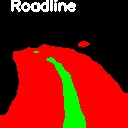

In [12]:
camera.observe(update, names='value')
time.sleep(1.01)
camera.unobserve(update, names='value')
robot.stop()

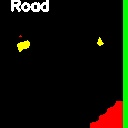

In [22]:
camera.observe(update, names='value')

In [23]:
camera.unobserve(update, names='value')
robot.stop()

In [19]:
robot.stop()

In [23]:
# camera.unobserve(update, names='value')
camera_link.unlink()
camera.release_camera()

ValueError: list.remove(x): x not in list